# Radio Access Network

Radio Access Network (RAN) is an important part of network communication systems, responsible for connecting used devices such as smartphones and radio machines to a wireless network. 

Optimizing the Radio Access Network involves various tasks that make it challenging to optimize a network efficiently. These tasks include resource allocation, locating transmission devices, such as antennas, to enhance coverage according to the overall consumption. Ideally, the optimization of a RAN will maximize the resource utilization of the network, save operational costs to the owner of the network.

In this case of RAN, the solution is the positions of the set of antennas we have in a region that that has consumers spread in various locations. Finding good positions of antennas with a limited number of antennas is very complex to optimize and find a good solution in polynomial time.

## 1. Define problem classically with pyomo

 - We have a limited number of antennas defined by $N$.
 - We have a set of potential locations: $\{1,2,3,...,M\}$, where $M>N$
 - We limit certain locations with an overlap, not to use 2 antennas.

### Mathematical definition

Each location is a binary variable $x_{i}$ that is 1 if we put antenna there and 0 if we don't put in that location. Each location is charachterized with certain consumption $c_{i}$.  

Mathematically, it is translated into objective function which aims to maximized its coverage:

$$
\max_{x} \sum_{i} c_{i}x_{i}
$$

Now, we add the constraints, such as the number of antennas:

$$
\sum_{i} x_{i} \leq N
$$

We can also add a constraint that prevent an ovelap between antennas. All sets of neighboring antenna sites $\{n_{0},n_{1},...,n_{k}\}$ will have only 1 anntenna on the ground:

$$
\sum_{i}^{k} x_{n_{i}} == 1
$$

### Defining Pyomo model

In [1]:
# Import relevant packages

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd
import pyomo.environ as pyo

# potenital locations
M = 13
# number of antennas
N = 7

# consumption coefficient
c_vec = np.random.rand(1, M)[0]

neighbors1 = [1, 3, 4]
neighbors2 = [0, 5]
neighbors3 = [6, 9]

In [2]:
model = pyo.ConcreteModel()

# define the variables
model.x = pyo.Var(range(M), domain=pyo.Binary)

x_variables = np.array(list(model.x.values()))

# constriants
model.num_antennas = pyo.Constraint(expr=sum(x_variables[i] for i in range(M)) <= N)

model.neigh1 = pyo.Constraint(expr=sum(x_variables[i] for i in neighbors1) == 1)
model.neigh2 = pyo.Constraint(expr=sum(x_variables[i] for i in neighbors2) == 1)
model.neigh3 = pyo.Constraint(expr=sum(x_variables[i] for i in neighbors3) == 1)

model.obj = pyo.Objective(expr=x_variables @ c_vec, sense=pyo.maximize)

### Define QAOA parameters and synthesize

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`) and the `penalty_energy` to get results that satisfy your constraints. Be careful! large enrgy also can bring you away from the optimized solution:

In [3]:
from classiq import *
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=4, penalty_energy=3.0)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (max_iteration).

In [4]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=1.0)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [5]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [6]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    num_shots=3000,
    # backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [7]:
from classiq import show, synthesize

qprog = synthesize(qmod)
write_qmod(qmod, "radio_access_network_positioning_antennas")
show(qprog)

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/nadavyoran/.pyenv/versions/3.11.13/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x1082b9340> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/nadavyoran/.pyenv/versions/3.11.13/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x1082b9340> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/nadavyoran/.pyenv/versions/3.11.13/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context:

Quantum program link: https://platform.classiq.io/circuit/36pyGdPoyltMPFVkjKVear2tfhr


### Executing the hybrid algorithm

We now solve the problem using the generated circuit by using the execute method:

In [8]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

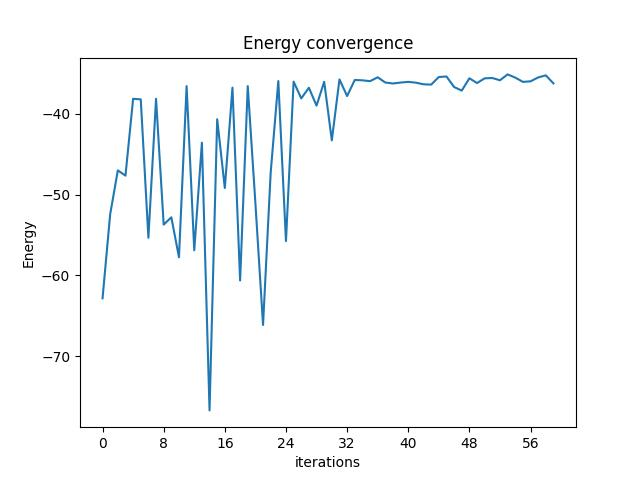

In [9]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

### Analyze results

We can also examine the statistics of the algorithm:

In [10]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)

optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
916,0.000333,5.117951,"[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]",1
562,0.000333,2.448870,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]",1
1519,0.000333,2.197017,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0]",1
342,0.000333,2.016968,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]",1
708,0.000333,1.991353,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]",1


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

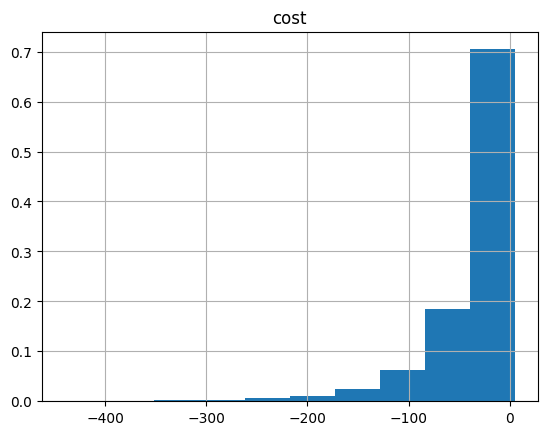

In [12]:
optimization_result.hist("cost", weights=optimization_result["probability"])